In [28]:
import datajoint as dj
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set_context("talk")

dj.blob.use_32bit_dims = True  # necessary for pd.blob read



import behav_viz.ingest as ingest
import behav_viz.visualize as viz
import behav_viz.utils as utils
from behav_viz.utils import plot_utils as pu
FIGURES_PATH = utils.dir_utils.get_figures_path("rats", "alpha")
import sys
sys.path.append('/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/meetings')
from TCM_mtg_2024_09_05_FixationExperiment import *
import config_alpha_experiment as alpha_config
# settings
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Animals

In [29]:
date_min = alpha_config.ALPHA_START_DATES["alpha_1"]
tdf = ingest.create_trials_df.create_trials_df_from_dj(
    alpha_config.ALPHA_ANIMALS, date_min
)
tdf = ingest.drop_dates(tdf, alpha_config.ALPHA_DATE_DROPS)

[2024-09-22 10:09:14,899][WARNING]: MySQL server has gone away. Reconnecting to the server.


animal_id R040
Fetched 56 dates from Sessions table from 2024-07-20 to 2024-09-21 for R040

animal_id R041
Fetched 59 dates from Sessions table from 2024-07-20 to 2024-09-21 for R041

animal_id R042
Fetched 59 dates from Sessions table from 2024-07-20 to 2024-09-21 for R042

animal_id R043
Fetched 60 dates from Sessions table from 2024-07-20 to 2024-09-21 for R043

animal_id R044
Fetched 50 dates from Sessions table from 2024-07-20 to 2024-09-21 for R044

animal_id R045
Fetched 58 dates from Sessions table from 2024-07-20 to 2024-09-21 for R045

animal_id R046
Fetched 59 dates from Sessions table from 2024-07-20 to 2024-09-21 for R046

animal_id R047
Fetched 53 dates from Sessions table from 2024-07-20 to 2024-09-21 for R047

animal_id R048
Fetched 49 dates from Sessions table from 2024-07-27 to 2024-09-21 for R048

animal_id R049
Fetched 47 dates from Sessions table from 2024-07-29 to 2024-09-20 for R049

animal_id R050
Fetched 51 dates from Sessions table from 2024-07-27 to 2024-09-2

In [30]:
aid_dropped_out = ["R044"]
aid_have_reached_target = (
    tdf.query("has_reached_target_fixation == 1 and animal_id not in @aid_dropped_out")
    .animal_id.unique()
    .tolist()
)
aid_still_growing = list(
    set(alpha_config.ALPHA_ANIMALS)
    - set(aid_have_reached_target)
    - set(aid_dropped_out)
)

growing_stages = [5, 6, 7]
probe_stages = [9, 10]

## Plot Over Days Summaries

### Probe Stages


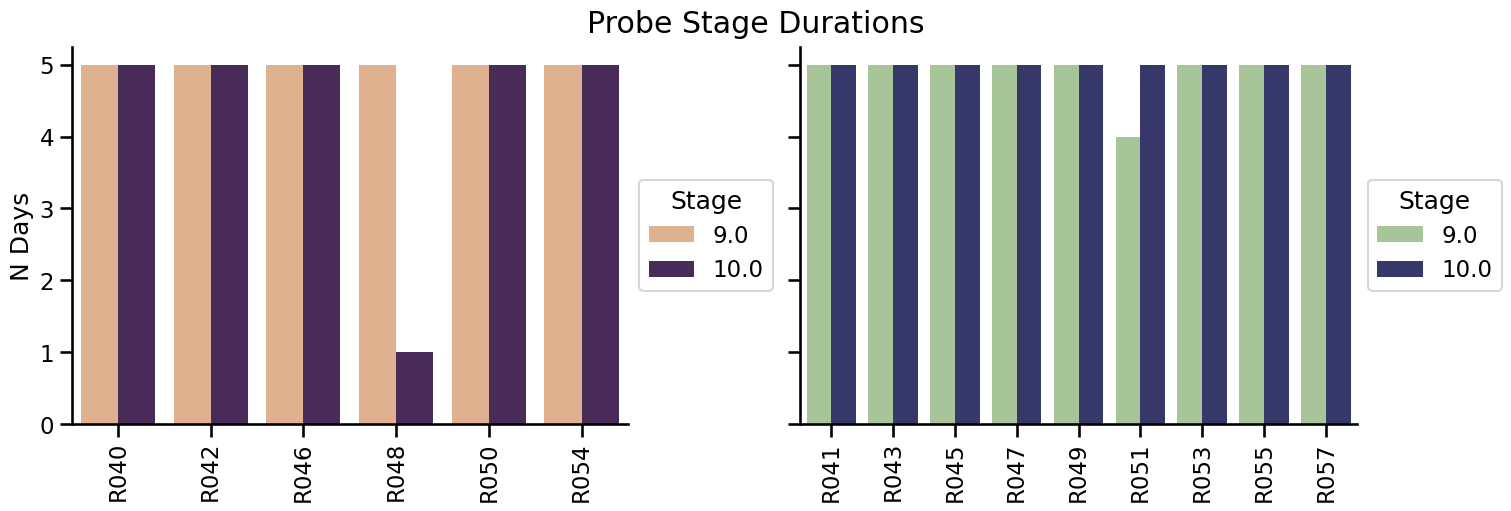

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
plt.suptitle("Probe Stage Durations")
for i, (exp, sub_df) in enumerate(tdf.groupby("fix_experiment")):
    viz.FixationGrower.exp_compare_alpha.plot_stage_in_stage_by_animal_single_experiment(
        sub_df, experiment=exp, min_stage=9, max_stage=10, ax=ax[i]
    )

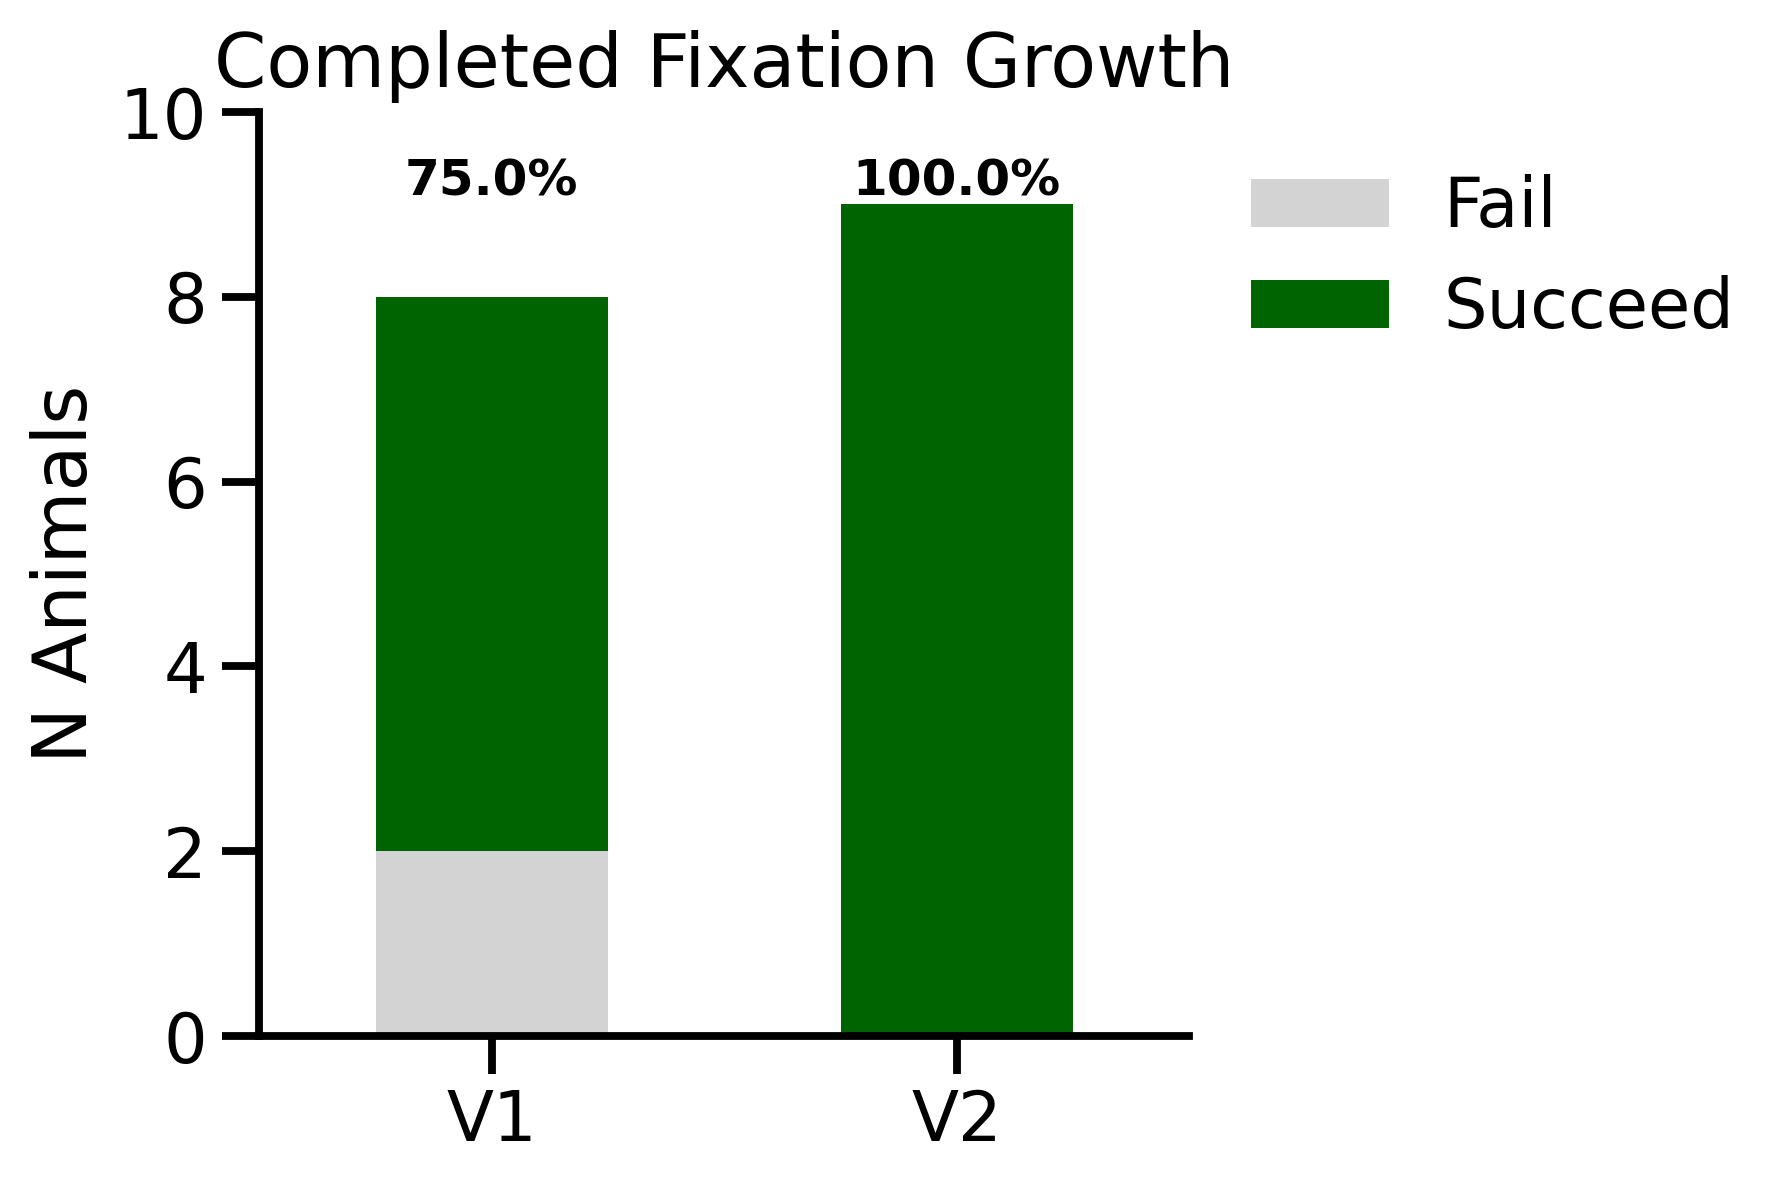

In [32]:
target_yield_df, success_rates = make_target_yield_df(
    aid_still_growing, aid_have_reached_target
)

fig, ax = pu.make_fig("s")

colors = {"Succeed": "darkgreen", "Fail": "lightgray"}

# Pivot the DataFrame to get the data in the right format for stacking
df_pivot = target_yield_df.pivot(
    index="fix_experiment", columns="outcome", values="count"
)

# Plot the stacked bar chart
df_pivot.plot(
    kind="bar", stacked=True, color=[colors[col] for col in df_pivot.columns], ax=ax
)


x_pos = [0, 1]
for rate, x in zip(success_rates, x_pos):
    ax.text(
        x,
        9.1,
        str(round(rate * 100, 1)) + "%",
        ha="center",
        fontsize=12,
        fontweight="black",
    )

# Add labels and title
ax.set(ylabel=("N Animals"), xlabel="", ylim=(0, 10), title="Completed Fixation Growth")
ax.legend(title=None, bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

# unrotate x labels
ax.tick_params(rotation=0)

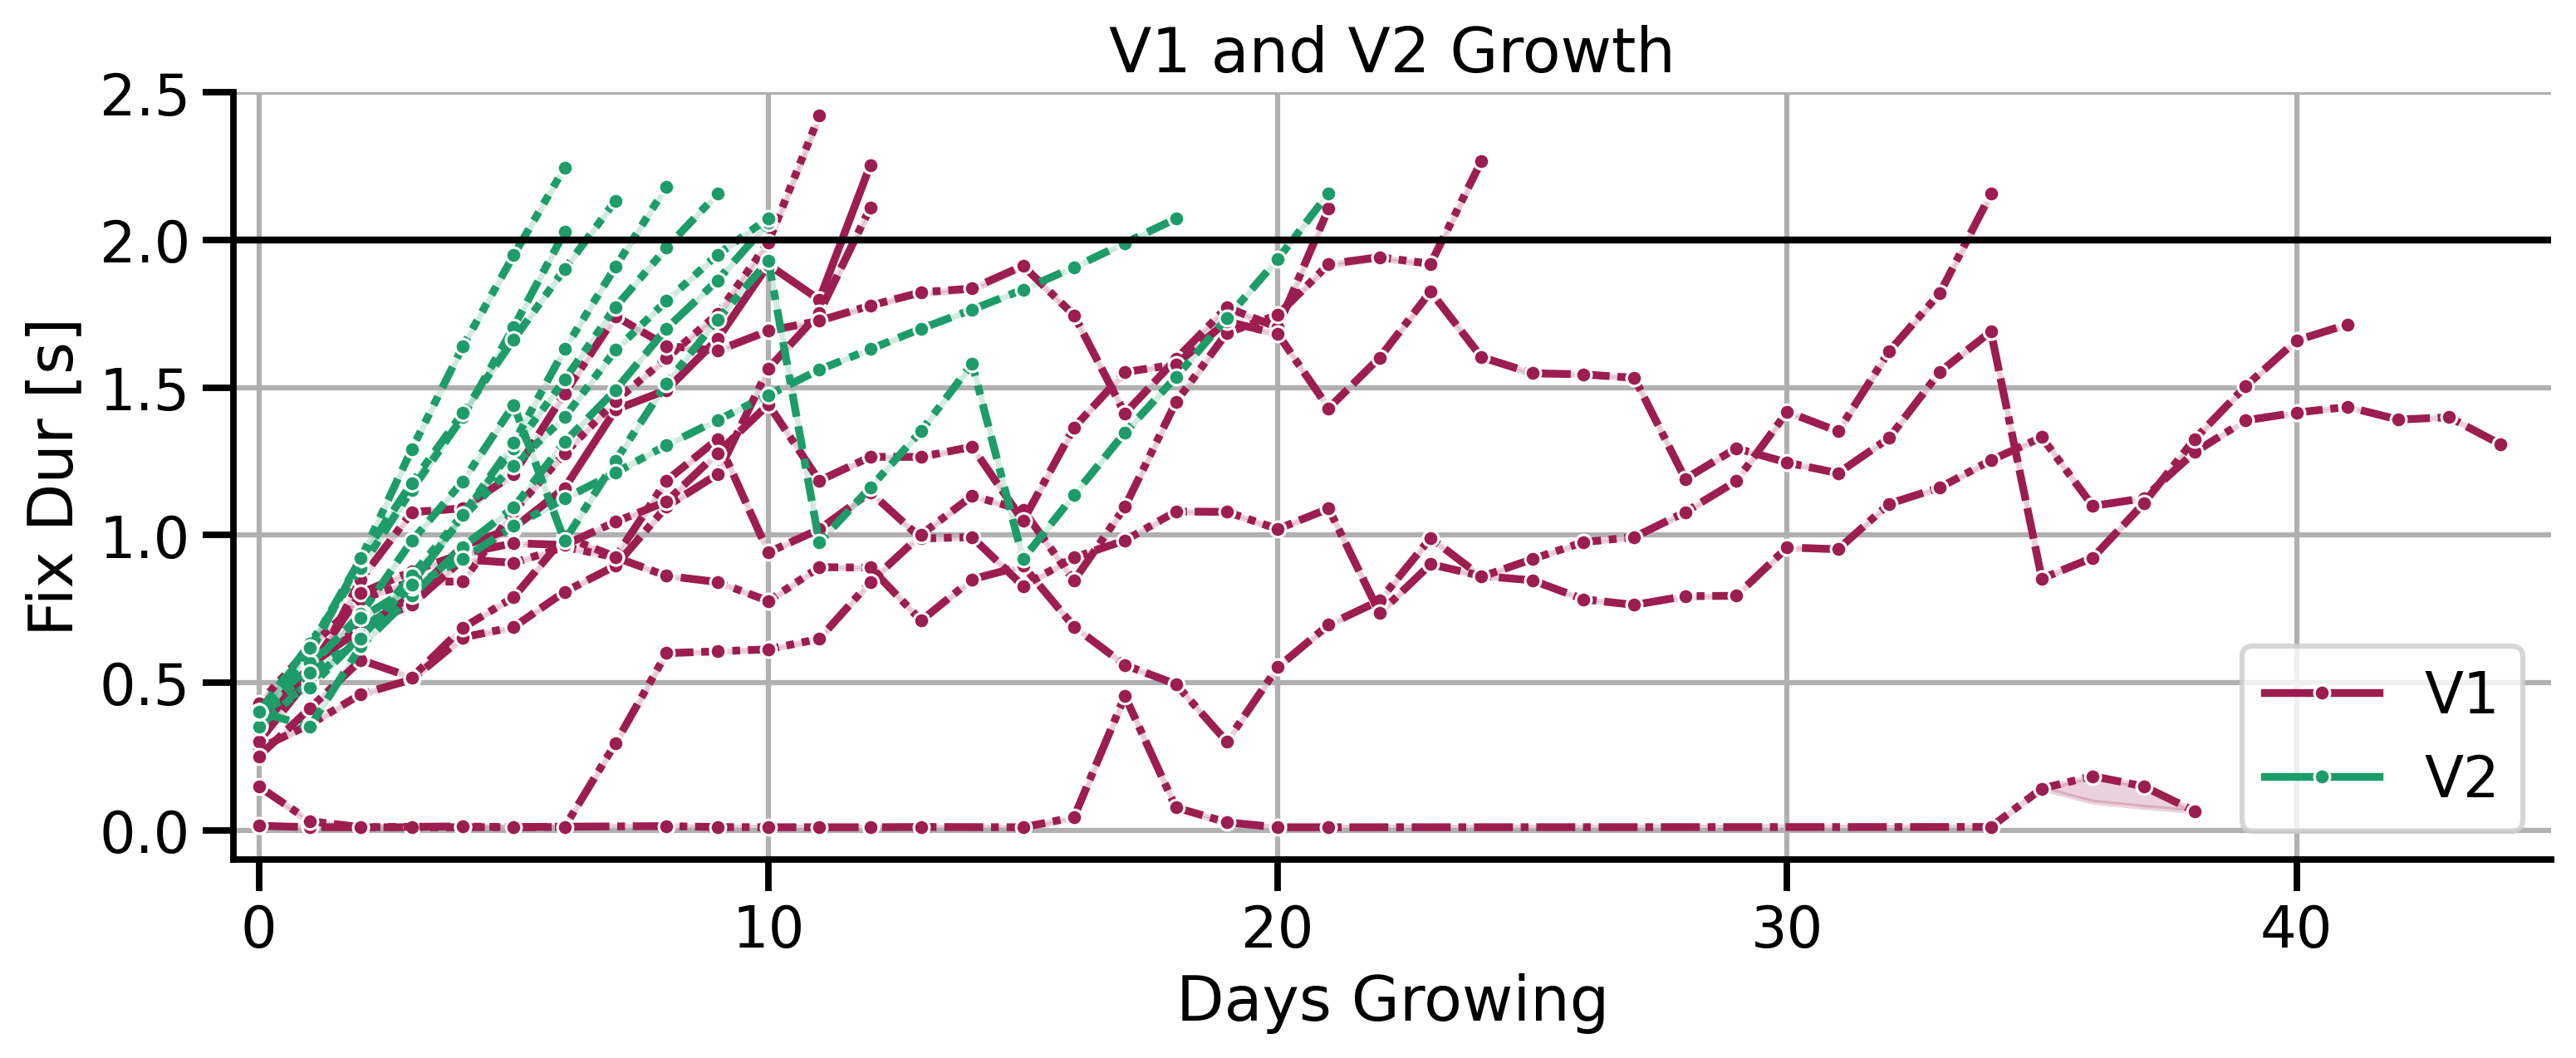

In [33]:
fig, ax = pu.make_fig()
xlabel = "Days Growing"
ylim = (-0.1, 2.5)
xlim = (-0.5, 45)
min_stage = 5
max_stage = 7
viz.FixationGrower.exp_compare_alpha.plot_fixation_dur_compare_experiment(tdf, ax=ax)

ax.set(xlabel=xlabel, ylim=ylim, xlim=xlim, title="V1 and V2 Growth")

sns.despine()

# Remove the default legend with style information
ax.get_legend().remove()

# Add a new legend with only the hue information
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3])

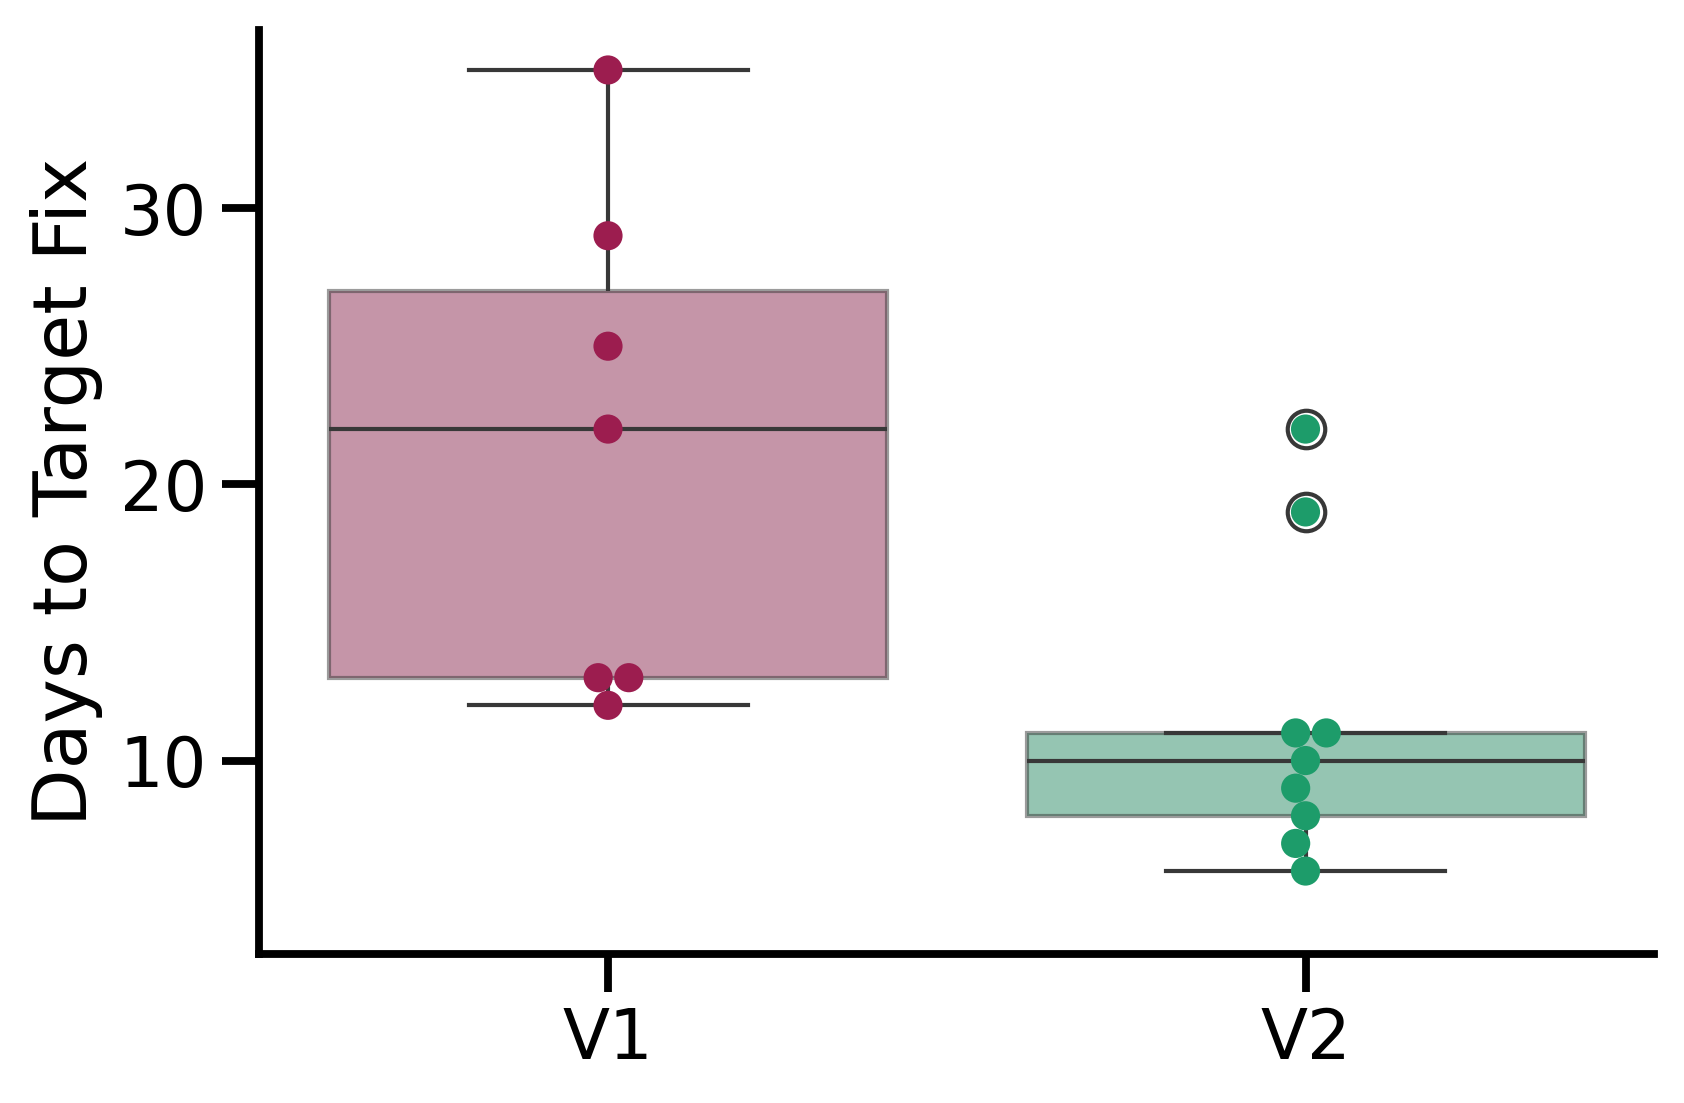

In [34]:
viz.FixationGrower.exp_compare_alpha.plot_days_to_reach_target_fix_boxplot_compare_experiment(
    tdf
)

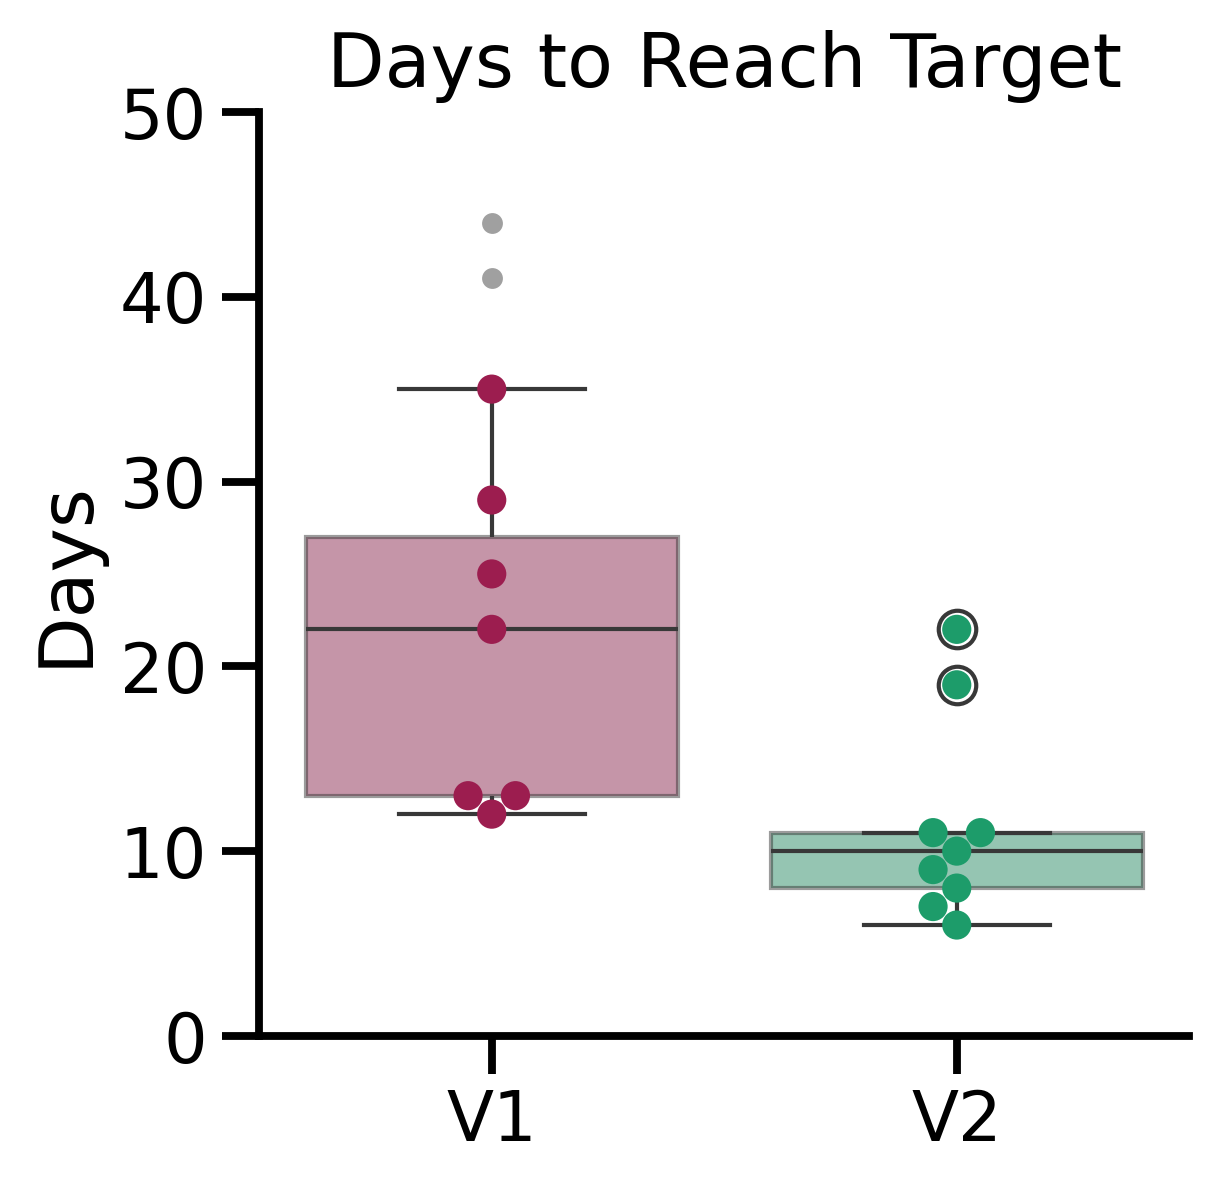

In [49]:
still_growing_df = make_still_growing_df(tdf, aid_still_growing)
fig, ax = pu.make_fig("s")
viz.FixationGrower.exp_compare_alpha.plot_days_to_reach_target_fix_boxplot_compare_experiment(
    tdf, ax=ax
)

sns.swarmplot(
    data=still_growing_df, x="fix_experiment", y="days", ax=ax, color="gray", alpha=0.75
)

_ = ax.set(ylabel="Days", xlabel="", ylim=(0, 50), title="Days to Reach Target")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


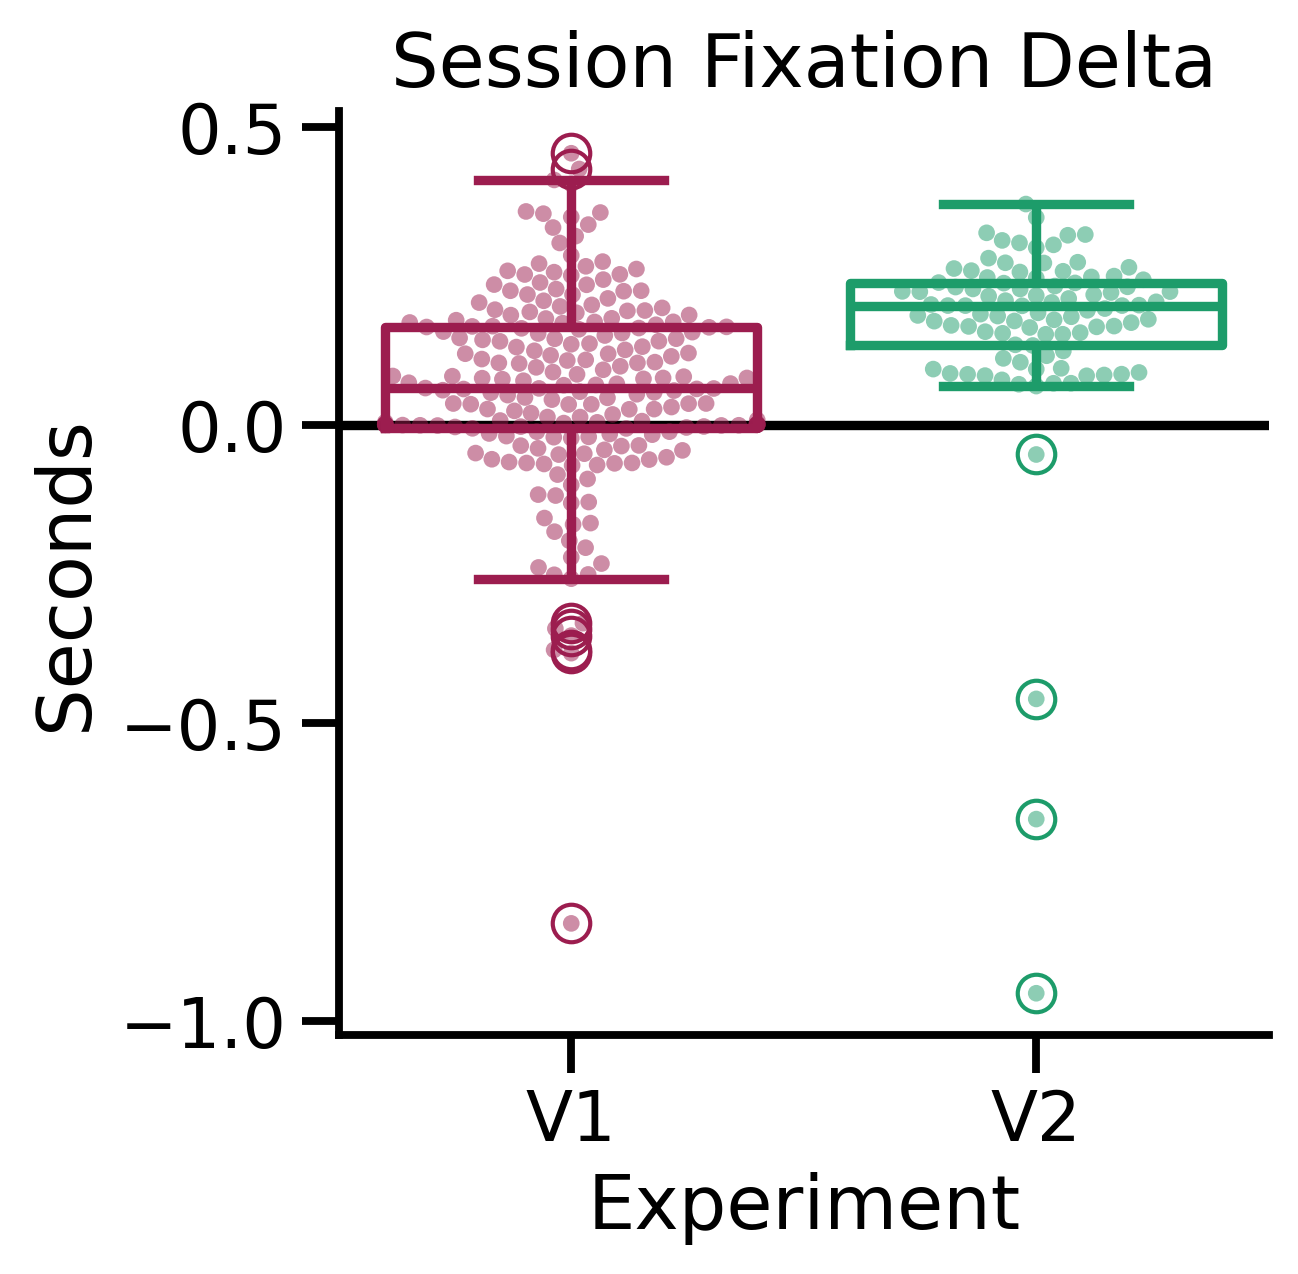

In [36]:
fix_delta_df = viz.FixationGrower.df_preperation.make_fixation_delta_df(
    tdf.query("stage < 8").copy()
)

fig, ax = pu.make_fig("s")

# Boxplot
sns.boxplot(
    data=fix_delta_df,
    x="fix_experiment",
    y="fixation_delta",
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    order=["V1", "V2"],
    palette=pu.ALPHA_PALLETTE,
    dodge=False,
    ax=ax,
    fill=False,
)

sns.swarmplot(
    data=fix_delta_df,
    x="fix_experiment",
    y="fixation_delta",
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    order=["V1", "V2"],
    palette=pu.ALPHA_PALLETTE,
    dodge=False,
    ax=ax,
    alpha=0.5,
    size=4,
)

sns.despine()


ax.axhline(0, color="black", zorder=0)

_ = ax.set(ylabel="Seconds", xlabel="Experiment", title="Session Fixation Delta")

[Text(0.5, 0, 'Seconds'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Session Fixation Delta')]

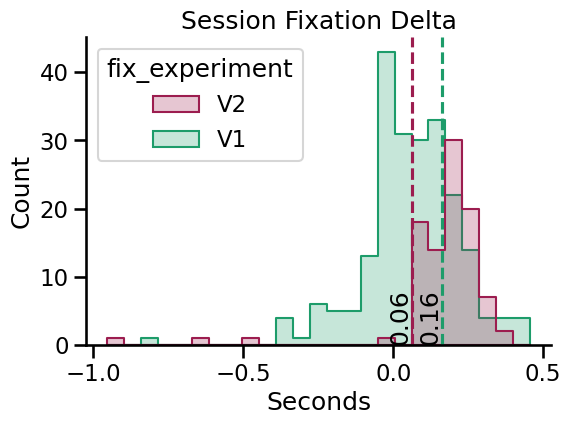

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=fix_delta_df,
    x="fixation_delta",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    element="step",
)

# mark the mean for each experiment
for ii, (exp, sub_df) in enumerate(
    fix_delta_df.groupby("fix_experiment", observed=True)
):
    mean = sub_df.fixation_delta.mean()
    ax.axvline(mean, color=pu.ALPHA_PALLETTE[ii], linestyle="--")
    ax.text(
        mean,
        0,
        f"{mean:.2f}",
        rotation=90,
        verticalalignment="bottom",
        horizontalalignment="right",
    )

sns.despine()

ax.set(xlabel="Seconds", ylabel="Count", title="Session Fixation Delta")

In [38]:
failed_fix_df = make_failed_fix_df_by_penalty_type(tdf)

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)


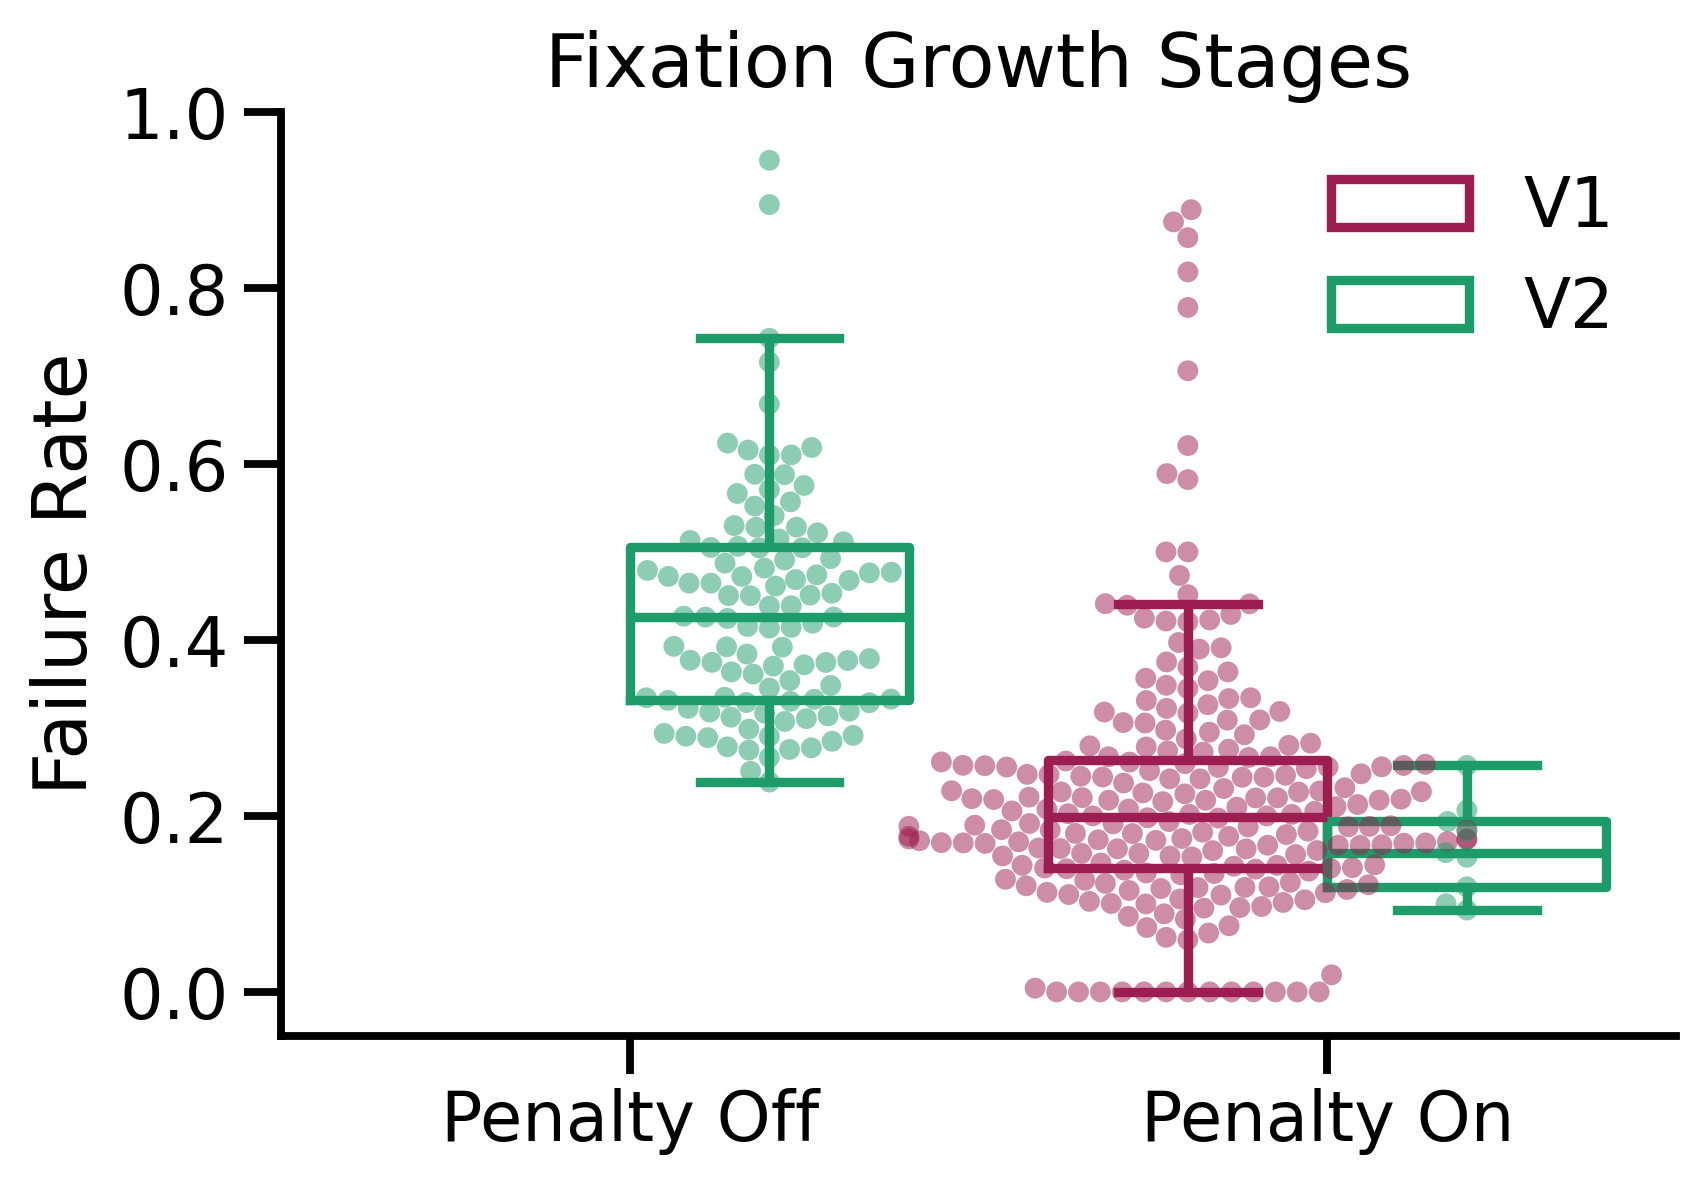

In [39]:
xlabel = ""
ylim = (-0.05, 1)
ylabel = "Failure Rate"

ax = box_swarm_v1_vs_v2(
    failed_fix_df.query("stage >= 5 and stage <=8"),
    x="type",
    y="failure_rate",
    order=["Penalty Off", "Penalty On"],
)

_ = ax.set(ylabel=ylabel, xlabel=xlabel, ylim=ylim, title="Fixation Growth Stages")

[Text(0, 0.5, 'Failure Rate'),
 Text(0.5, 0, 'Days Relative to Penalty On'),
 Text(0.5, 1.0, 'V2 Penalty'),
 (-0.05, 1.0)]

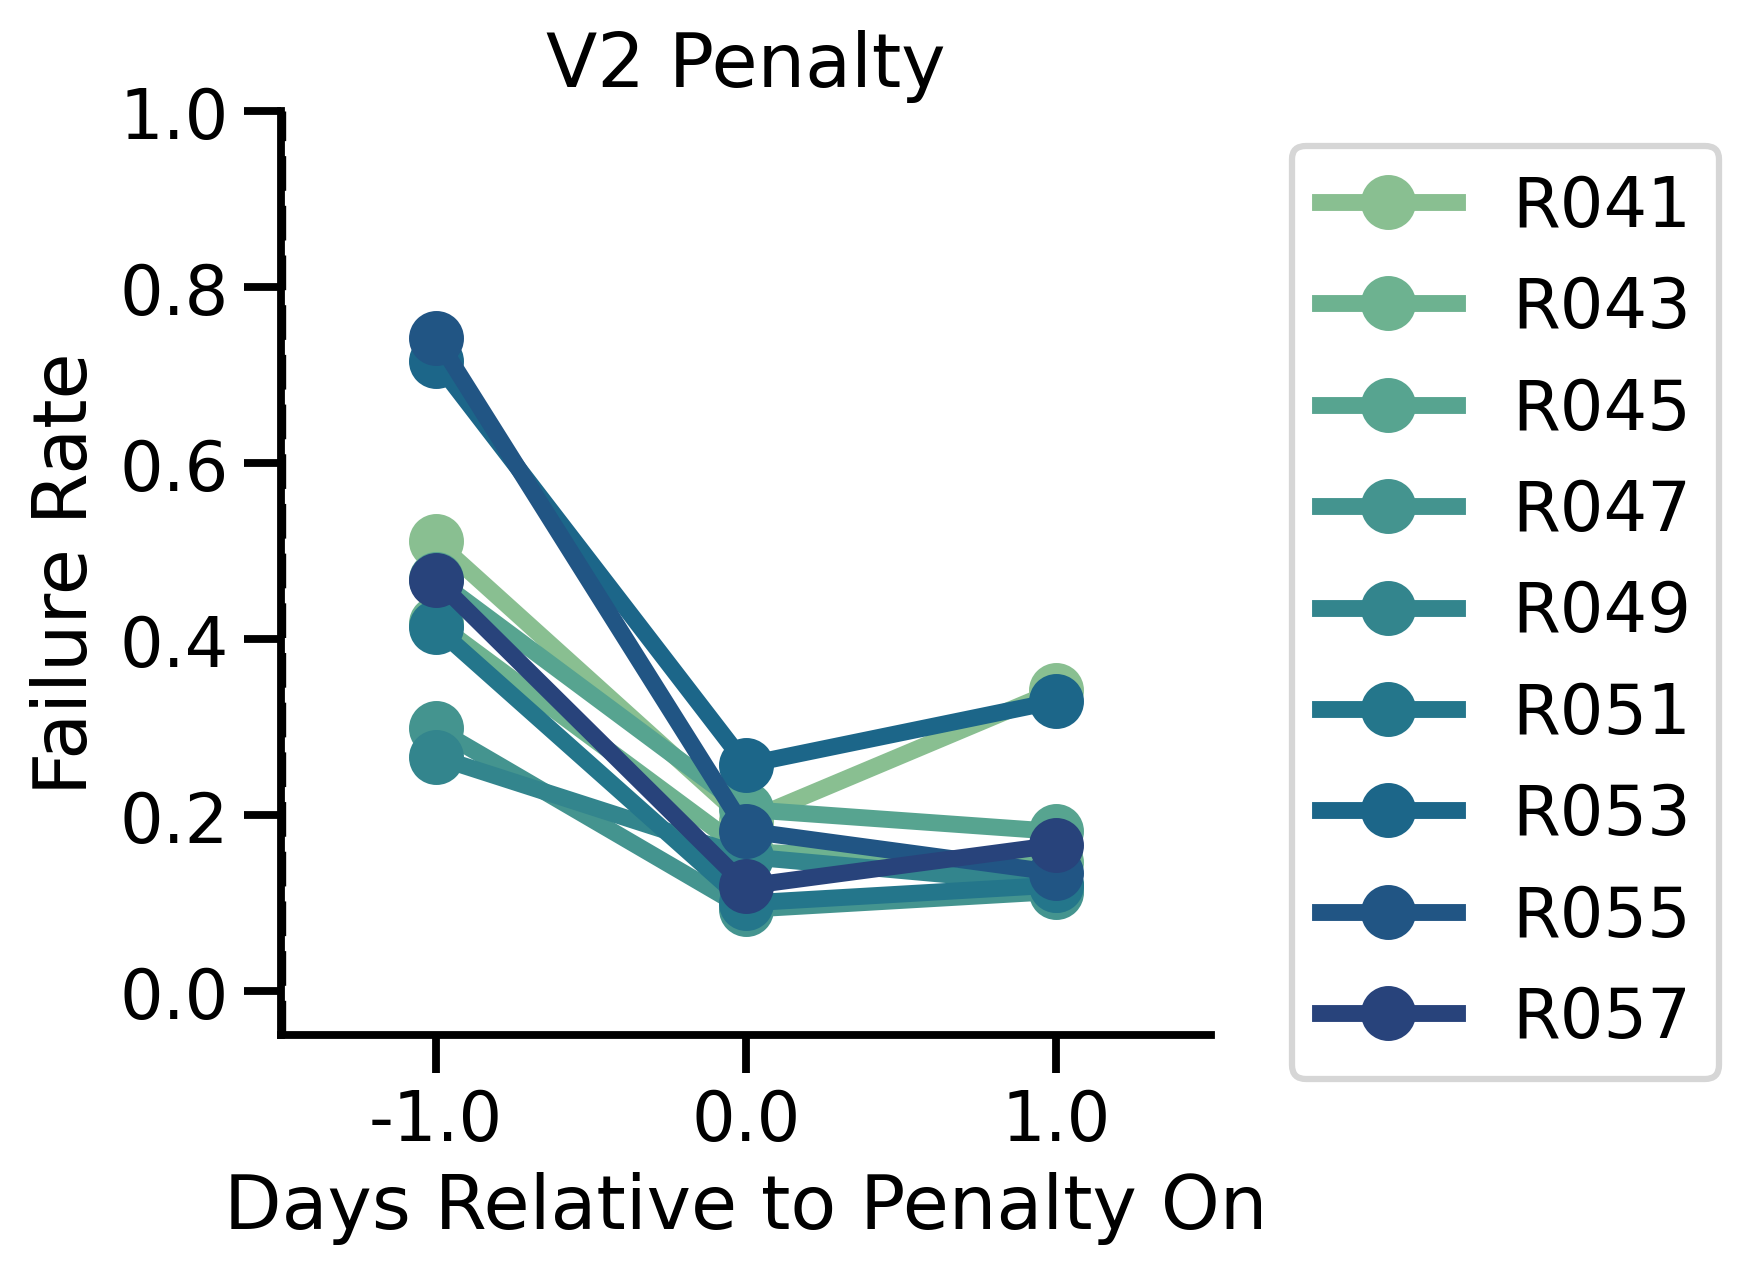

In [40]:
v2_penalty_on_df = failed_fix_df.query("fix_experiment == 'V2'").copy()
v2_penalty_on_df = viz.df_preperation.compute_days_relative_to_stage(
    failed_fix_df, 8
).reset_index()

fig, ax = pu.make_fig("s")
sns.despine()
day_range = [-1, 1]

plot_df = v2_penalty_on_df.query(
    "days_relative_to_stage_8 >= @day_range[0] and days_relative_to_stage_8 <= @day_range[1]"
)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="failure_rate",
    hue="animal_id",
    palette=pu.ALPHA_V2_palette,
    ax=ax,
)
ax.axvline(-0.5, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set(
    ylabel=ylabel,
    xlabel="Days Relative to Penalty On",
    title="V2 Penalty",
    ylim=ylim,
)

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_44566/2533193154.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Stable\nDelay", "Random\nDelay"])


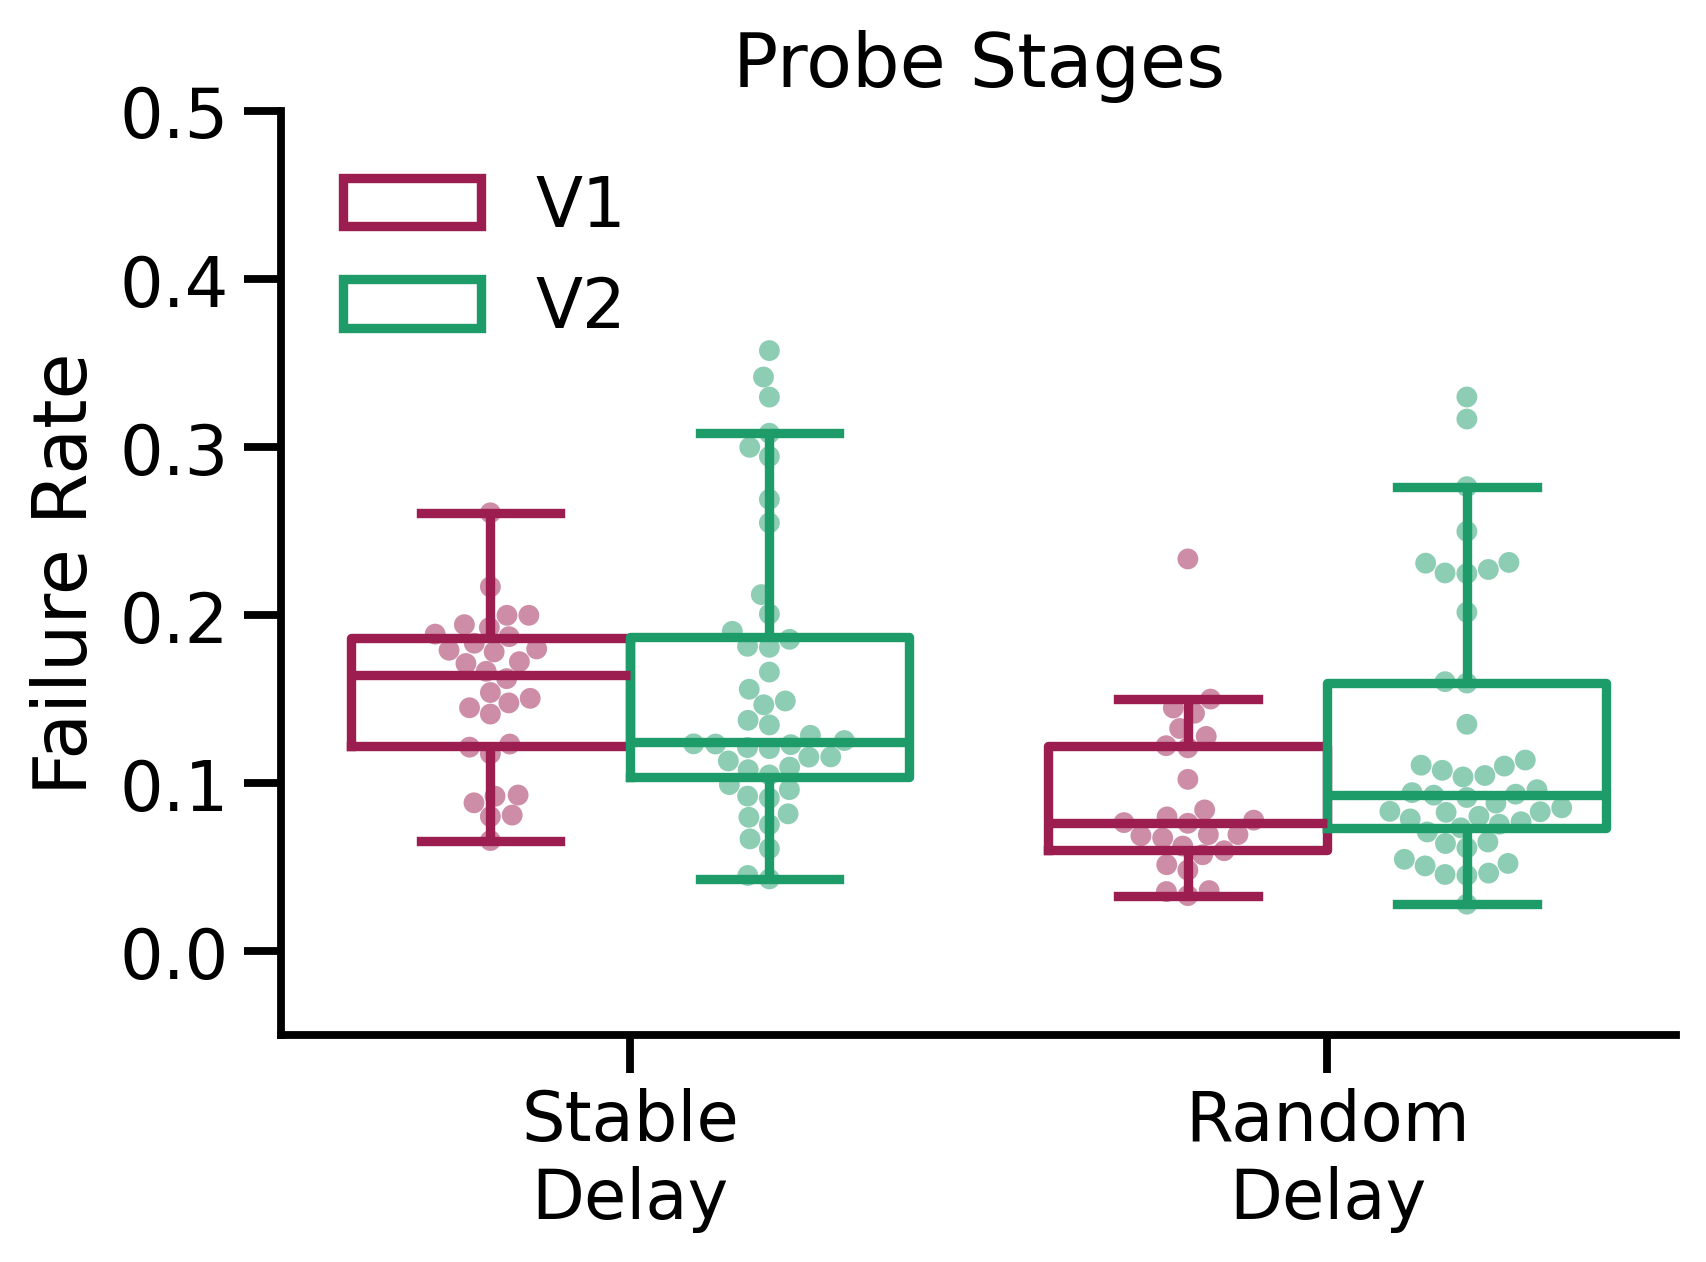

In [41]:
ylim = (-0.05, 0.5)

probe_failed_fix = failed_fix_df.query("stage in @probe_stages").copy()

fig, ax = pu.make_fig("m")
ax = box_swarm_v1_vs_v2(
    probe_failed_fix,
    order=None,
    x="stage",
    y="failure_rate",
    ax=ax,
)

_ = ax.set(
    xlabel="",
    ylabel=ylabel,
    title="Probe Stages",
    ylim=ylim,
)

ax.set_xticklabels(["Stable\nDelay", "Random\nDelay"])

ax.legend(title=None, frameon=False, loc="upper left")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_44566/4162141745.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  round(medians[xtick], 2),


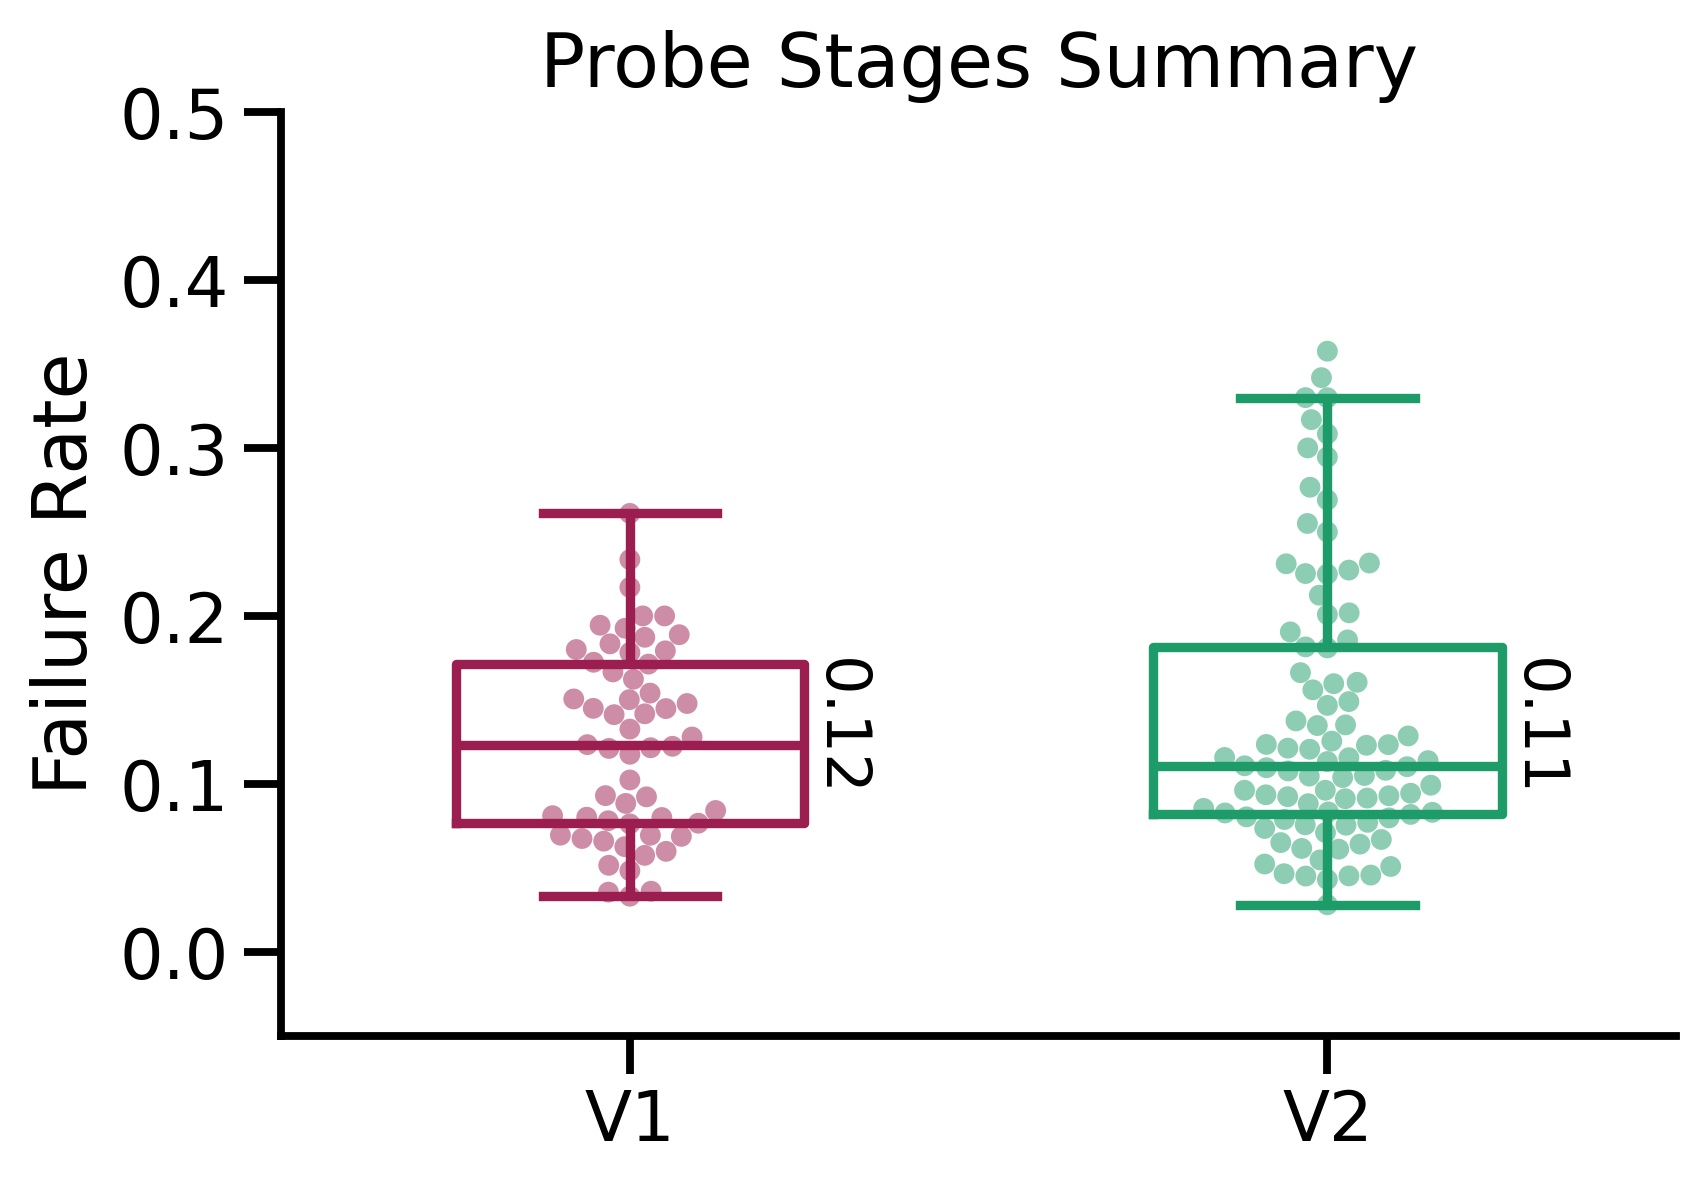

In [42]:
fig, ax = pu.make_fig("m")
sns.despine()

sns.boxplot(
    data=probe_failed_fix,
    x="fix_experiment",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    fill=None,
    showfliers=False,
    width=0.5,
)

sns.swarmplot(
    data=probe_failed_fix,
    x="fix_experiment",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    legend=False,
    alpha=0.5,
)

_ = ax.set(
    xlabel="",
    ylabel=ylabel,
    title="Probe Stages Summary",
    ylim=ylim,
)

# print median for each group on box plot in vertical text next to the boxplot in black
medians = probe_failed_fix.groupby(["fix_experiment"])["failure_rate"].median()
# Step 2: Calculate a small offset to ensure the text doesn't overlap with the boxplot
vertical_offset = probe_failed_fix["failure_rate"].median() * 0.05

# Step 3: Plot the medians on the boxplot with 90-degree rotation
for xtick in ax.get_xticks():
    ax.text(
        xtick + 0.3,  # Slightly adjust the x position to place text on the edge
        0.1,
        round(medians[xtick], 2),
        horizontalalignment="center",
        size="small",
        color="black",
        rotation=270,  # Rotate the text 90 degrees
    )

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)


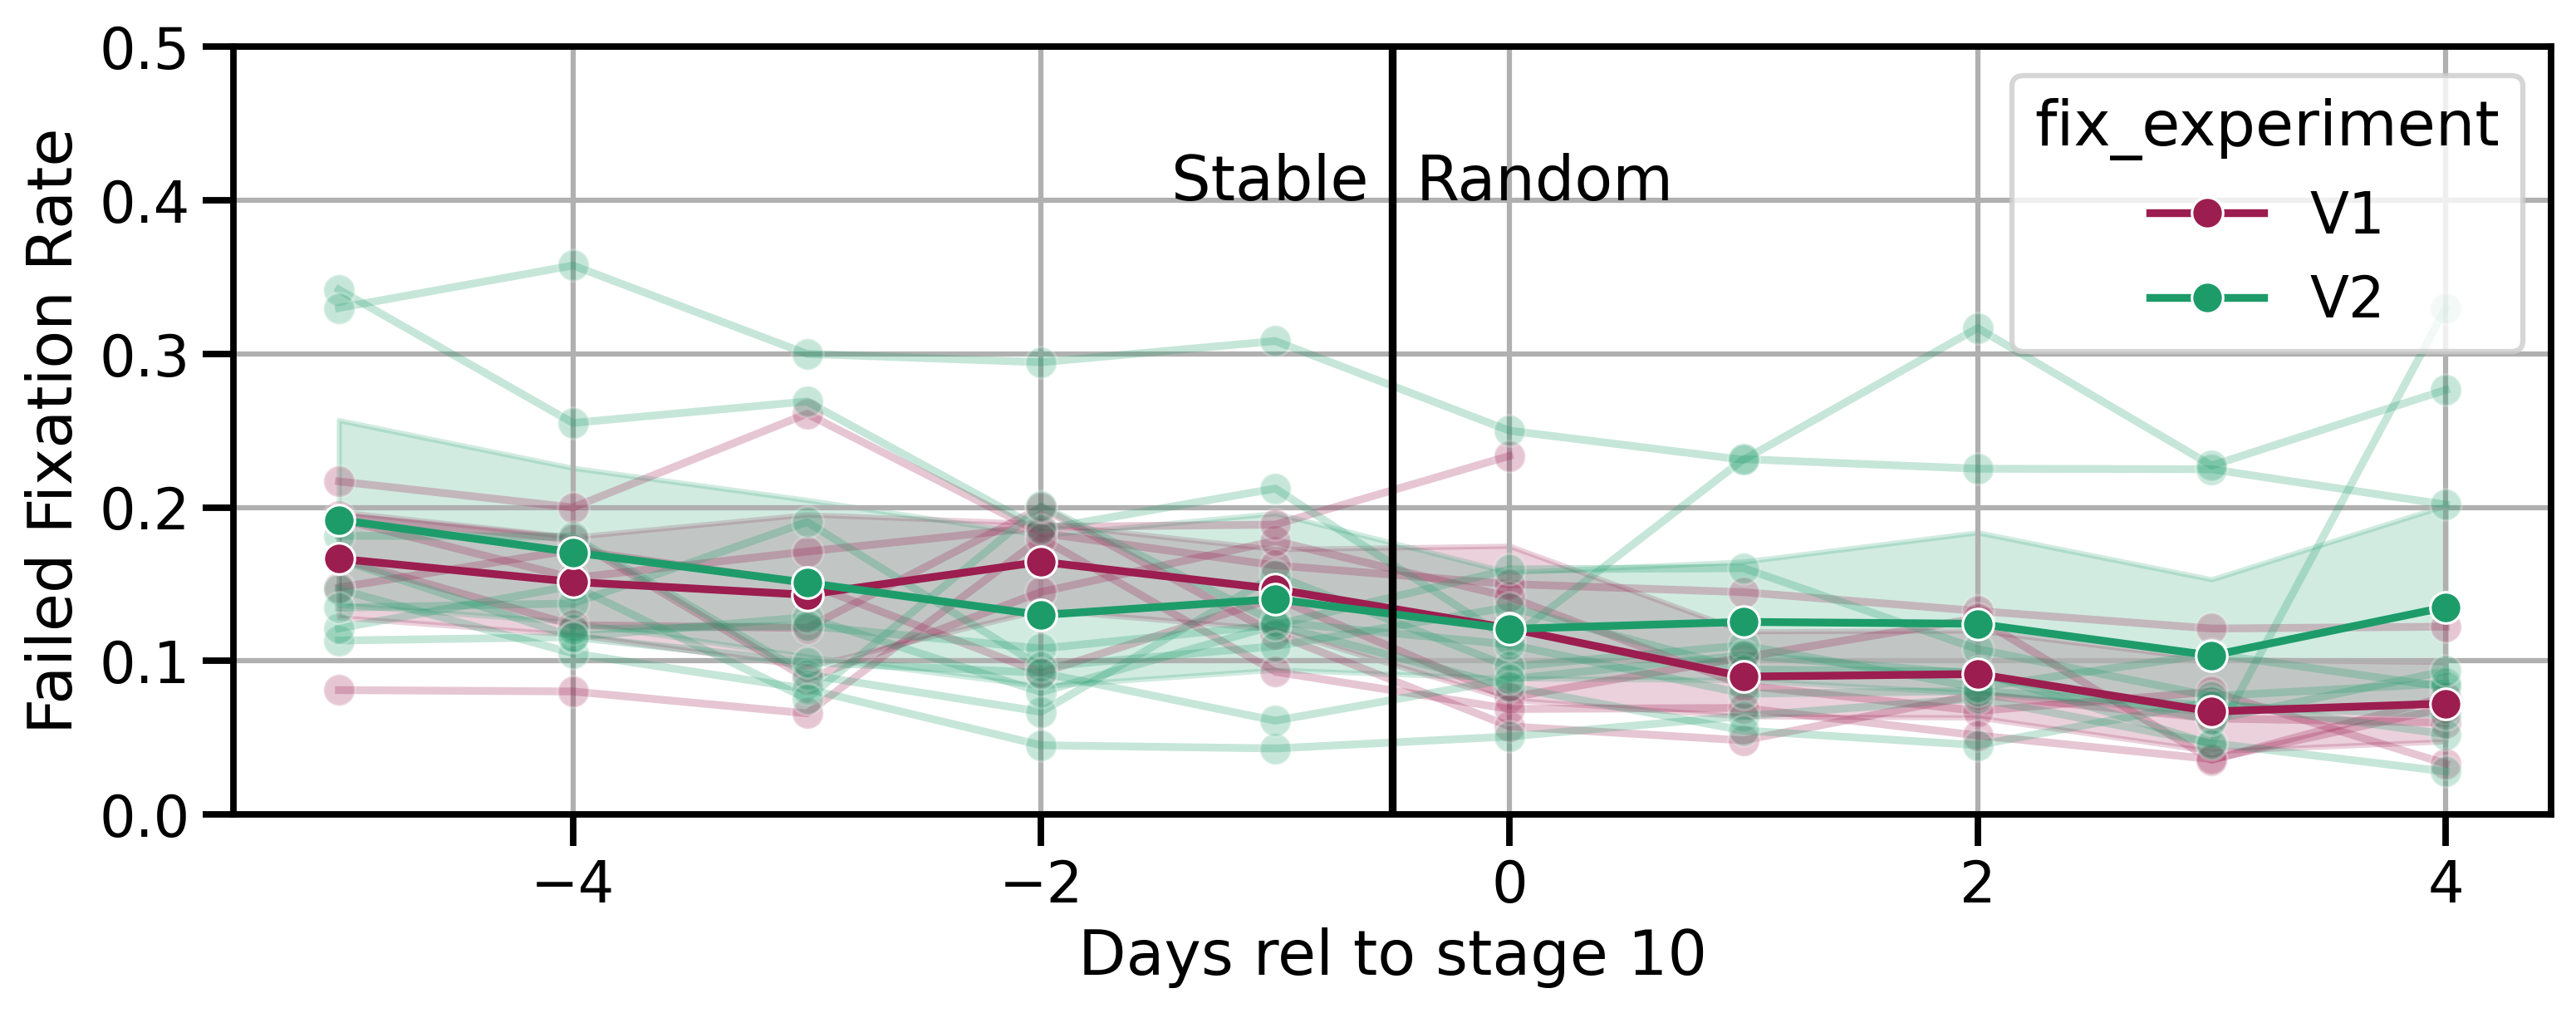

In [43]:
fig, ax = pu.make_fig()
viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_compare_experiment(
    tdf, plot_individuals=True, min_stage=9, max_stage=10, relative_to_stage=10, ax=ax
)

ax.grid()

ax.axvline(-0.5, color="black")
_ = ax.text(-0.4, 0.4, "Random", horizontalalignment="left")
_ = ax.text(-0.6, 0.4, "Stable", horizontalalignment="right")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_44566/2681447378.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (exp, sub_df) in enumerate(tdf.groupby("fix_experiment")):
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame conca

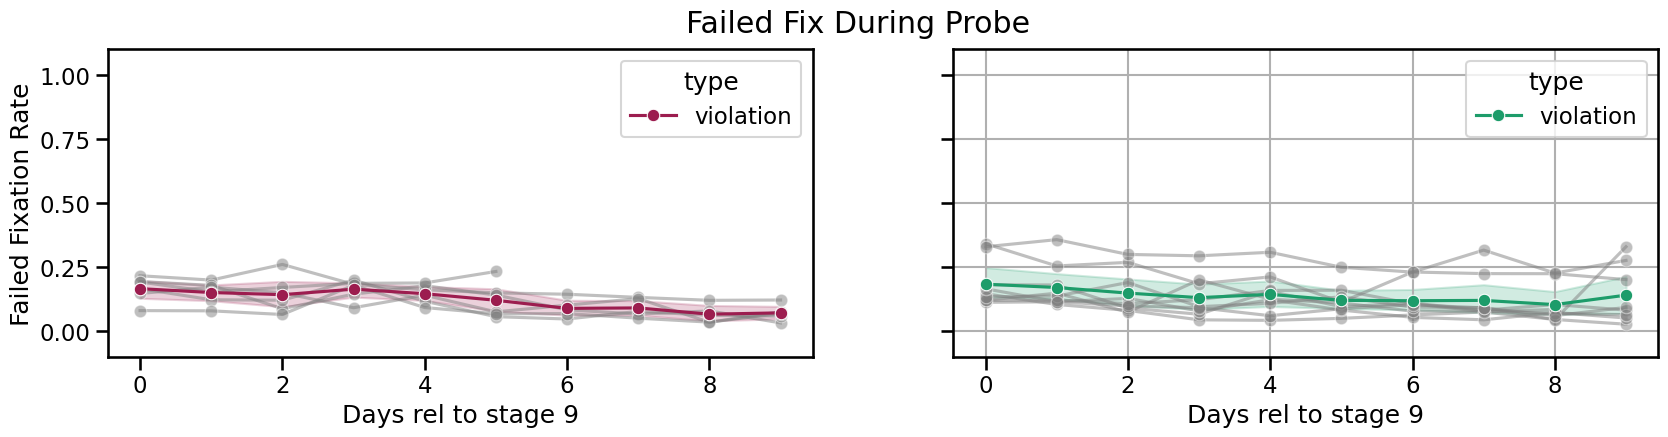

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4), sharex=True, sharey=True)
plt.suptitle("Failed Fix During Probe")

for i, (exp, sub_df) in enumerate(tdf.groupby("fix_experiment")):
    viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_single_experiment(
        sub_df,
        experiment=exp,
        ax=ax[i],
        title=exp,
        min_stage=9,
        max_stage=10,
        relative_to_stage=9,
    )
    ax[i].grid()

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)


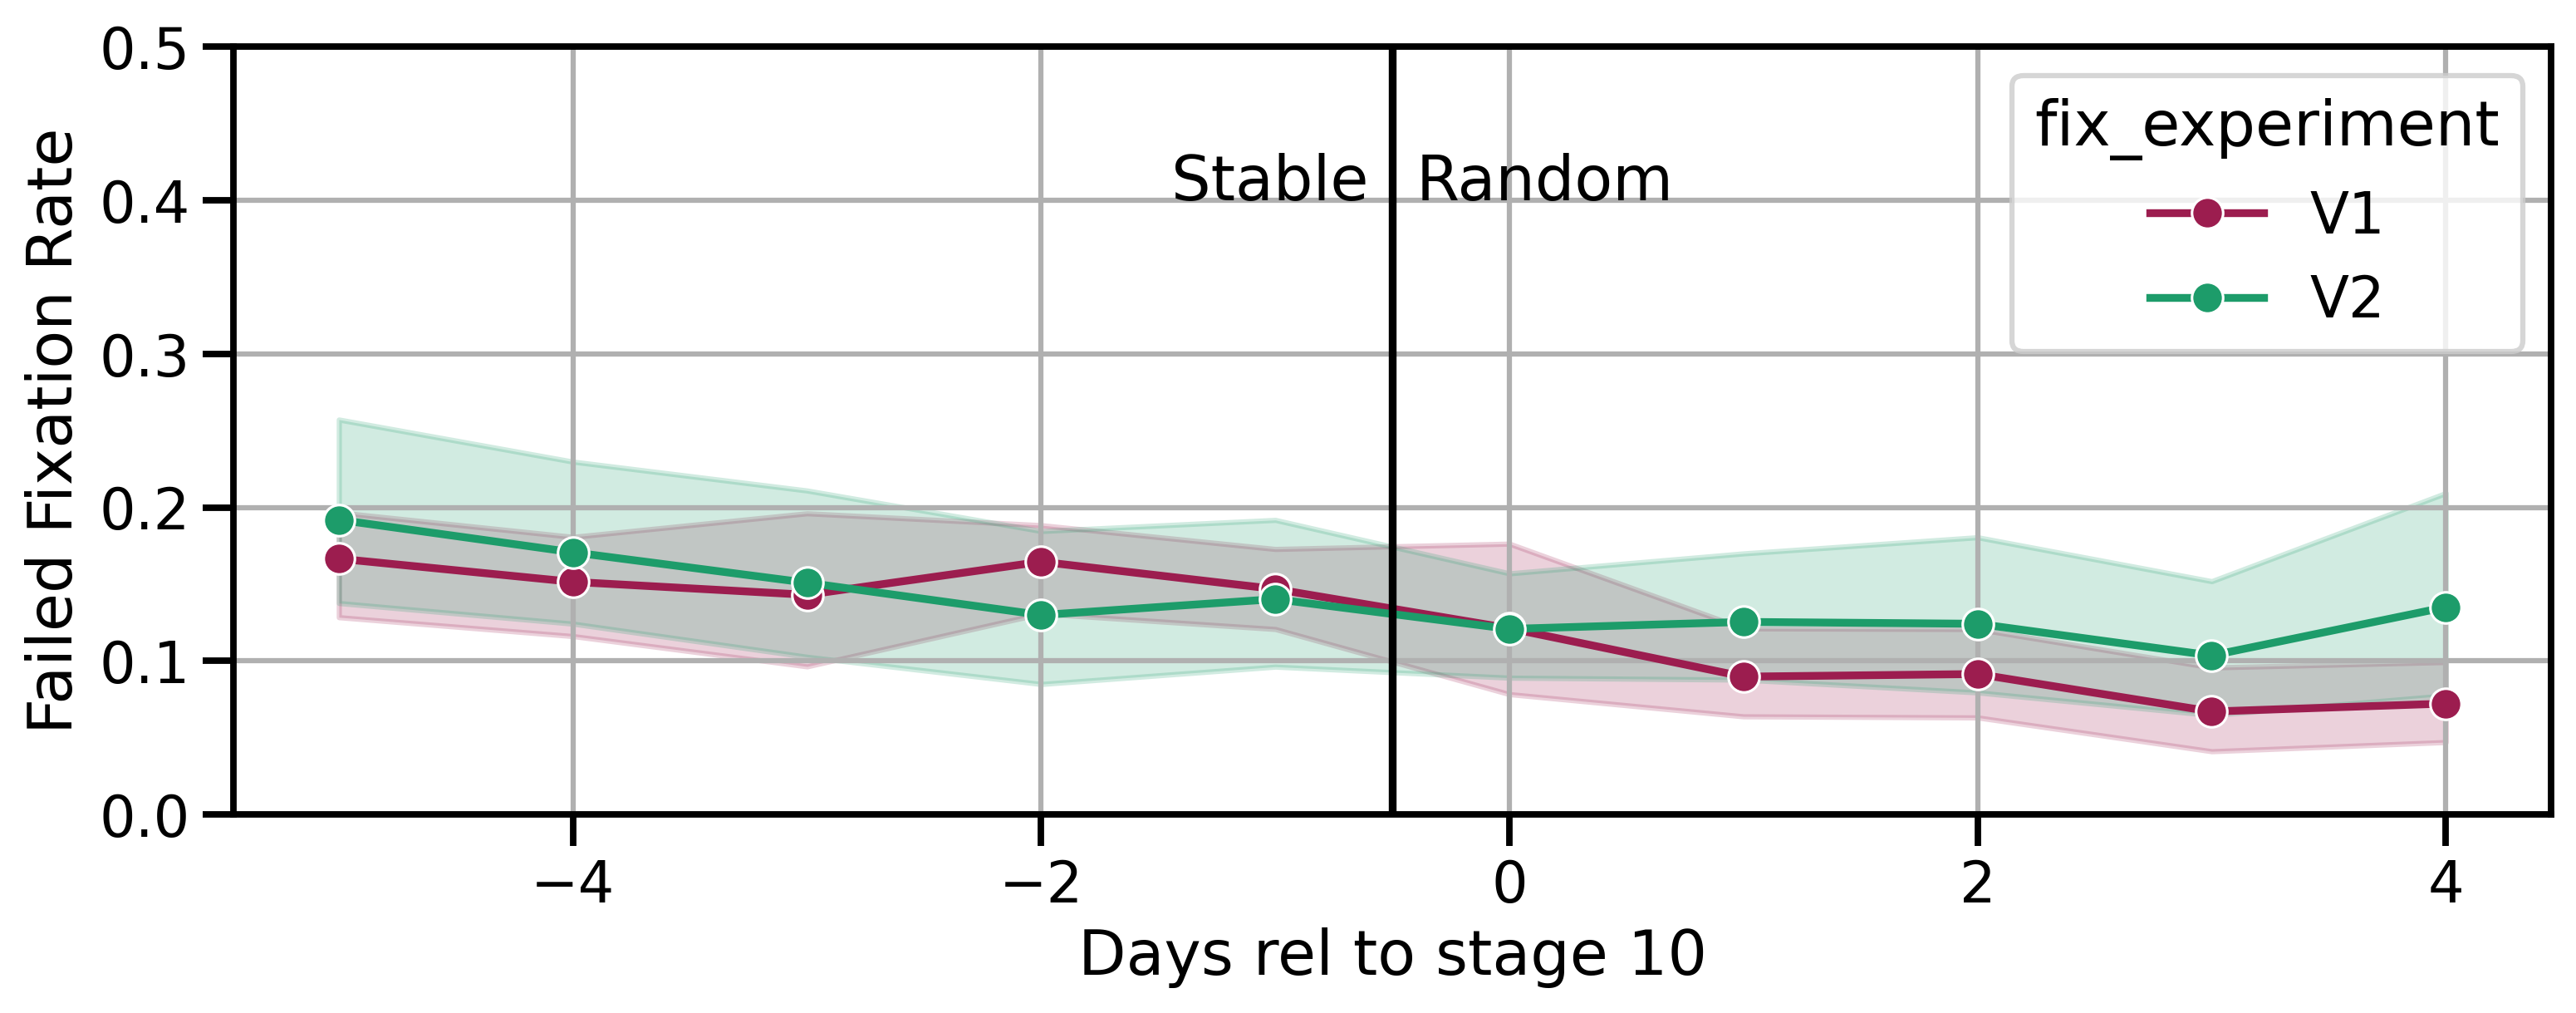

In [45]:
fig, ax = pu.make_fig()
viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_compare_experiment(
    tdf, plot_individuals=False, min_stage=9, max_stage=10, relative_to_stage=10, ax=ax
)

ax.axvline(-0.5, color="black")
_ = ax.text(-0.4, 0.4, "Random", horizontalalignment="left")
_ = ax.text(-0.6, 0.4, "Stable", horizontalalignment="right")

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)
/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_p

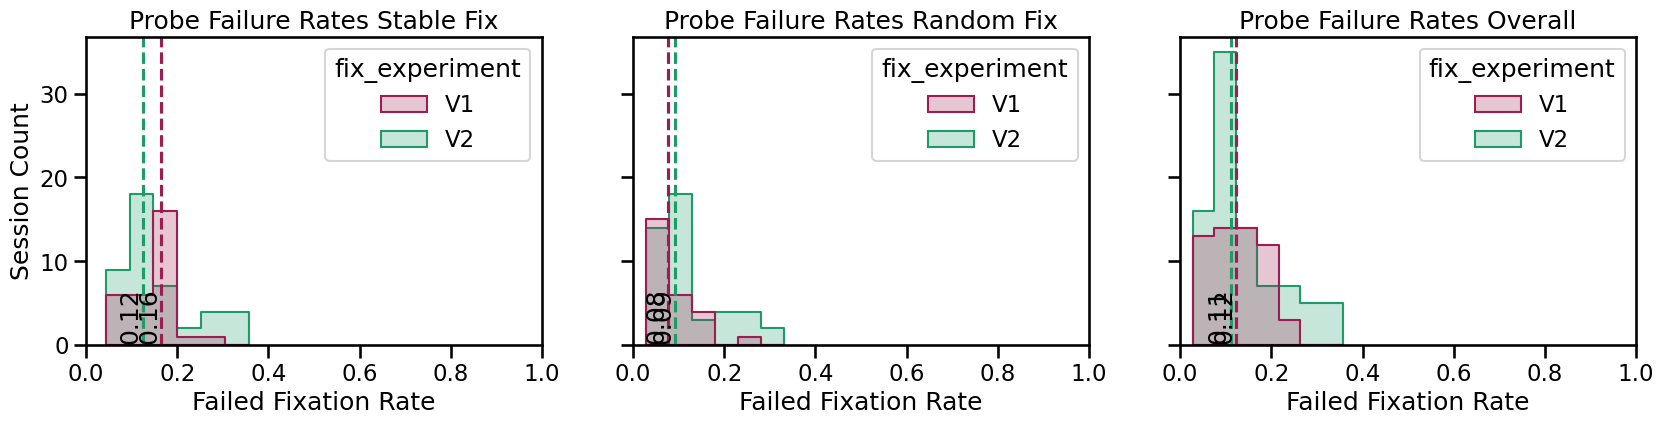

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_histogram_compare_experiment(
    tdf,
    ax=ax[0],
    min_stage=9,
    max_stage=9,
    title="Probe Failure Rates Stable Fix",
)

viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_histogram_compare_experiment(
    tdf,
    ax=ax[1],
    min_stage=10,
    max_stage=10,
    title="Probe Failure Rates Random Fix",
)

viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_histogram_compare_experiment(
    tdf,
    ax=ax[2],
    min_stage=9,
    max_stage=10,
    title="Probe Failure Rates Overall",
)

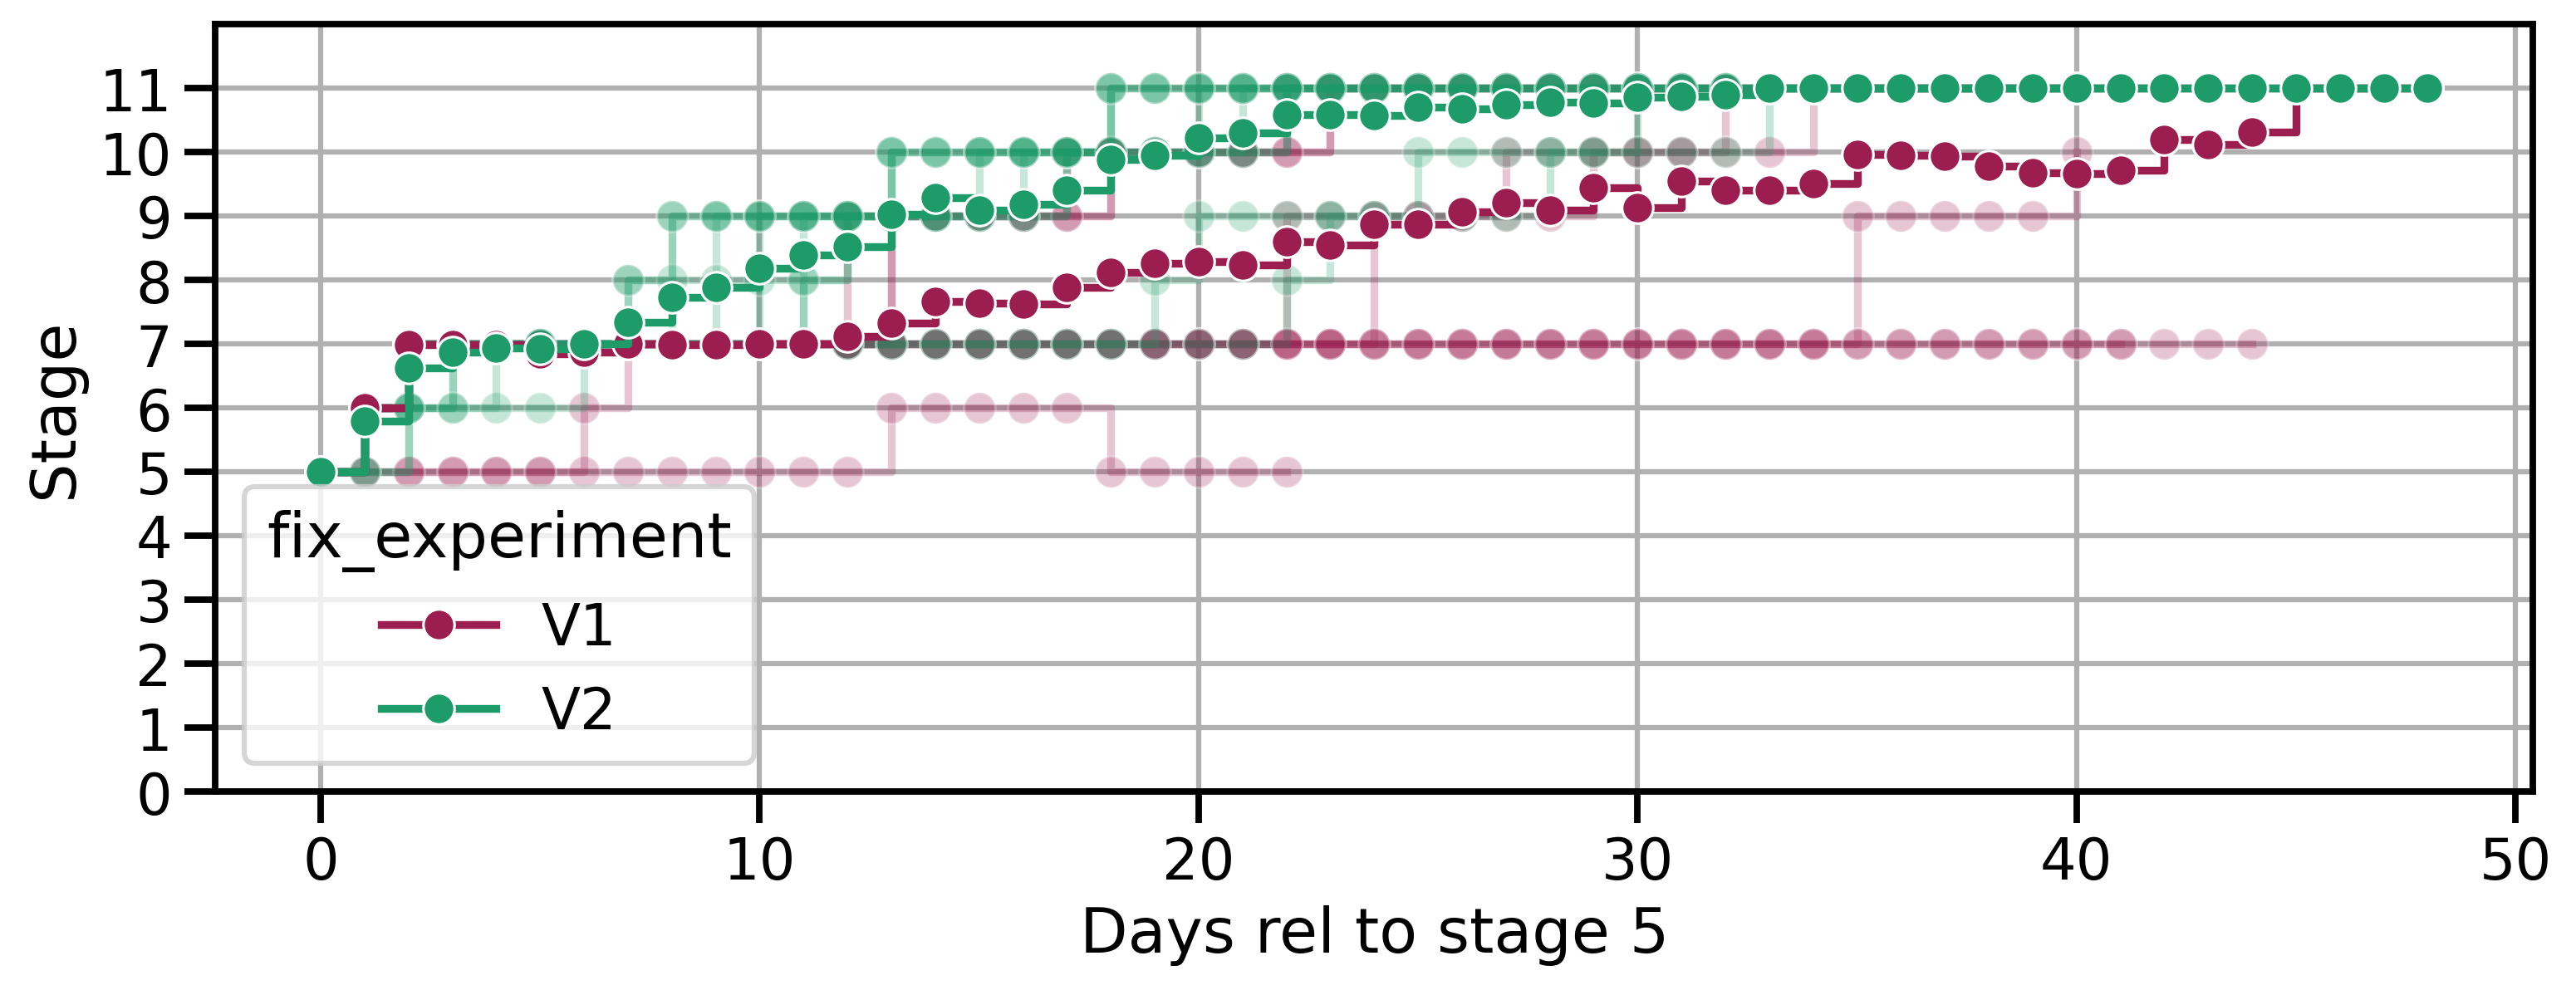

In [47]:
plot_df = tdf.query("stage >= 5").copy()
fig, ax = pu.make_fig()
viz.FixationGrower.exp_compare_alpha.plot_stage_compare_experiments(
    plot_df, relative_to_stage=5, ax=ax
)